In [3]:
# Install pyspark
!pip install pyspark

!pip install tensorflowonspark

# import all dependencies 
from pyspark.sql.functions import to_date, lower, regexp_replace, isnan, col, when, count, lit, collect_list, countDistinct, explode
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, TimestampType, IntegerType , BooleanType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score

from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import coalesce

!pip install tensorflow==2.10.0

from tensorflowonspark import TFCluster
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

spark = SparkSession.builder \
    .appName("Deep Learning Model") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "8g") \
    .config("spark.driver.maxResultSize", "2g") \
    .getOrCreate()



/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


In [4]:

# Read olympic_athletes
df_olympic_athletes = spark.read.csv("/content/olympic_athletes.csv", header=True, inferSchema=True)
df_olympic_athletes.show(5)
df_olympic_athletes.describe().show()
df_olympic_athletes.printSchema()


df_olympic_athletes = df_olympic_athletes.withColumn("games_participations", col("games_participations").cast("int"))


# Nombre total de participations par athlète
participations_par_athlete = df_olympic_athletes.groupBy("athlete_full_name").count().orderBy(col("count").desc())
participations_par_athlete.show(10)

# Nombre total de médailles par athlète
medailles_par_athlete = df_olympic_athletes.groupBy("athlete_full_name").agg(count("athlete_medals").alias("total_medailles")).orderBy(col("total_medailles").desc())
medailles_par_athlete.show(10)

# Répartition nombre des médailles par type
medailles_par_type = df_olympic_athletes.groupBy("athlete_medals").count().orderBy(col("count").desc())
medailles_par_type.show()


+--------------------+--------------------+--------------------+----------------+------------------+--------------+----+
|         athlete_url|   athlete_full_name|games_participations|      first_game|athlete_year_birth|athlete_medals| bio|
+--------------------+--------------------+--------------------+----------------+------------------+--------------+----+
|https://olympics....|Cooper WOODS-TOPA...|                   1|    Beijing 2022|              2000|          NULL|NULL|
|https://olympics....|      Felix ELOFSSON|                   2|PyeongChang 2018|              1995|          NULL|NULL|
|https://olympics....|       Dylan WALCZYK|                   1|    Beijing 2022|              1993|          NULL|NULL|
|https://olympics....|       Olli PENTTALA|                   1|    Beijing 2022|              1995|          NULL|NULL|
|https://olympics....|    Dmitriy REIKHERD|                   1|    Beijing 2022|              1989|          NULL|NULL|
+--------------------+----------

+----------------+-------------------+-------------------+------------------+----------------+-----------+---------+
|       game_slug|      game_end_date|    game_start_date|     game_location|       game_name|game_season|game_year|
+----------------+-------------------+-------------------+------------------+----------------+-----------+---------+
|    beijing-2022|2022-02-20 12:00:00|2022-02-04 15:00:00|             China|    Beijing 2022|     Winter|     2022|
|      tokyo-2020|2021-08-08 14:00:00|2021-07-23 11:00:00|             Japan|      Tokyo 2020|     Summer|     2020|
|pyeongchang-2018|2018-02-25 08:00:00|2018-02-08 23:00:00| Republic of Korea|PyeongChang 2018|     Winter|     2018|
|        rio-2016|2016-08-21 21:00:00|2016-08-05 12:00:00|            Brazil|        Rio 2016|     Summer|     2016|
|      sochi-2014|2014-02-23 16:00:00|2014-02-07 04:00:00|Russian Federation|      Sochi 2014|     Winter|     2014|
+----------------+-------------------+-------------------+------

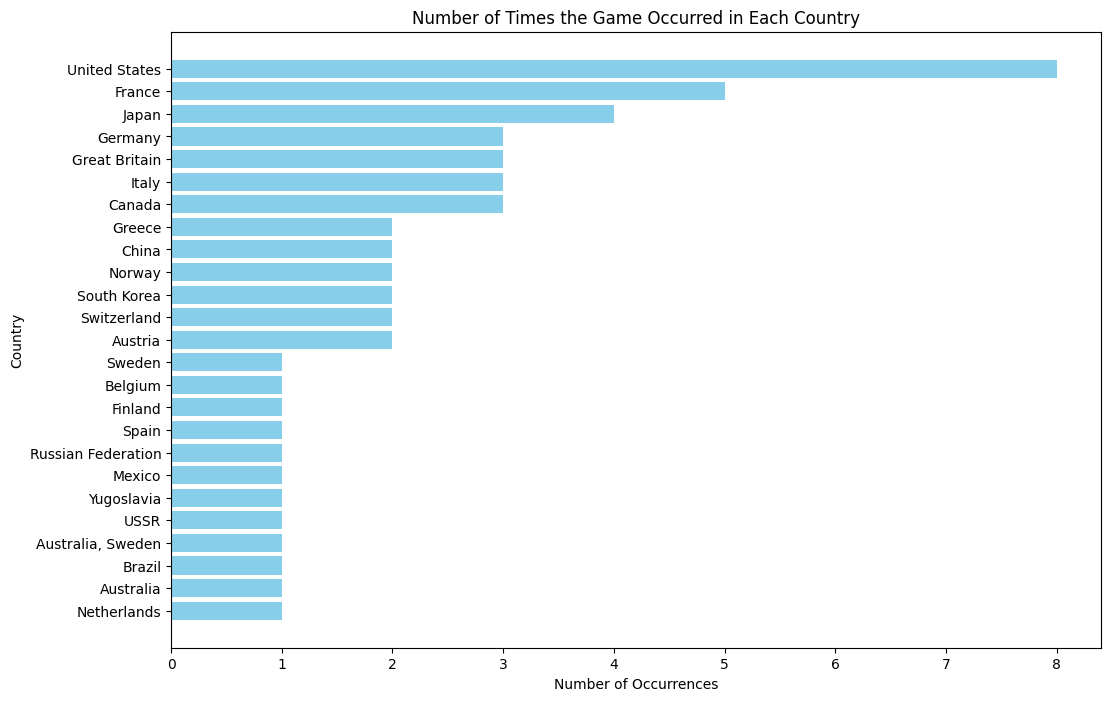

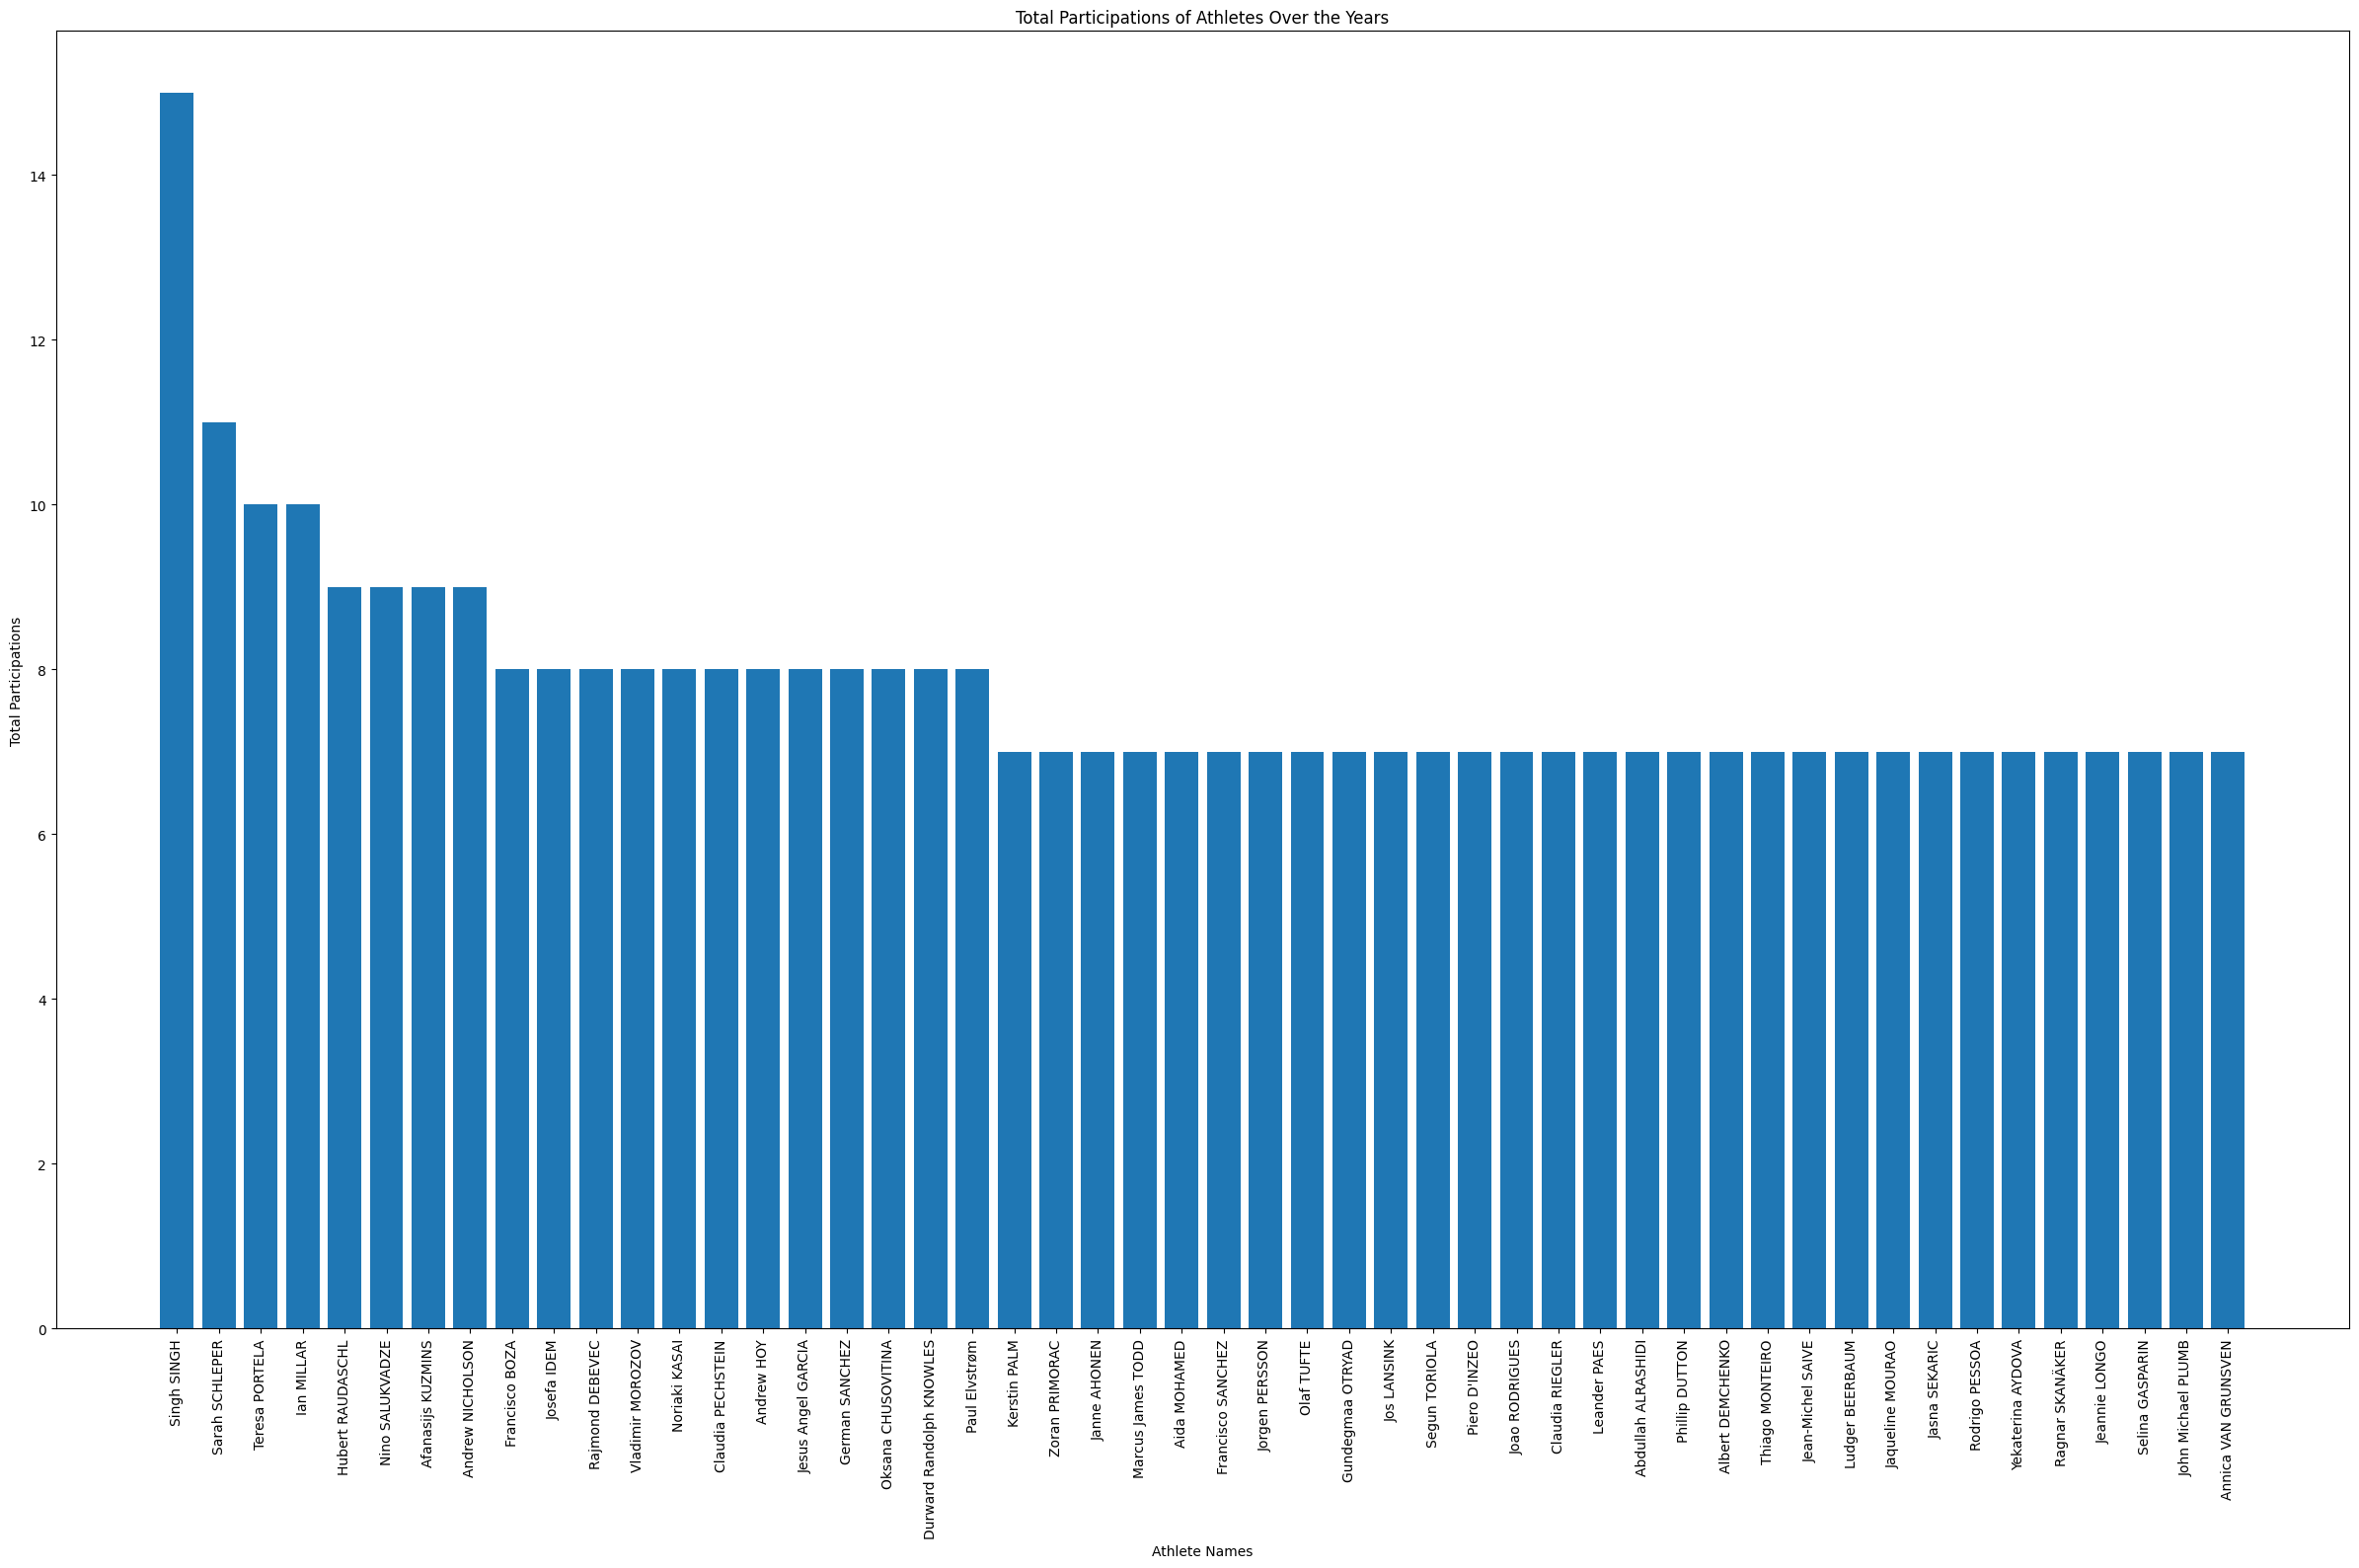

<ipython-input-5-bde3465465c2>:77: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.displot(data=df_athletes_hosts_pd, x="games_participations", hue="game_year", kind="kde")


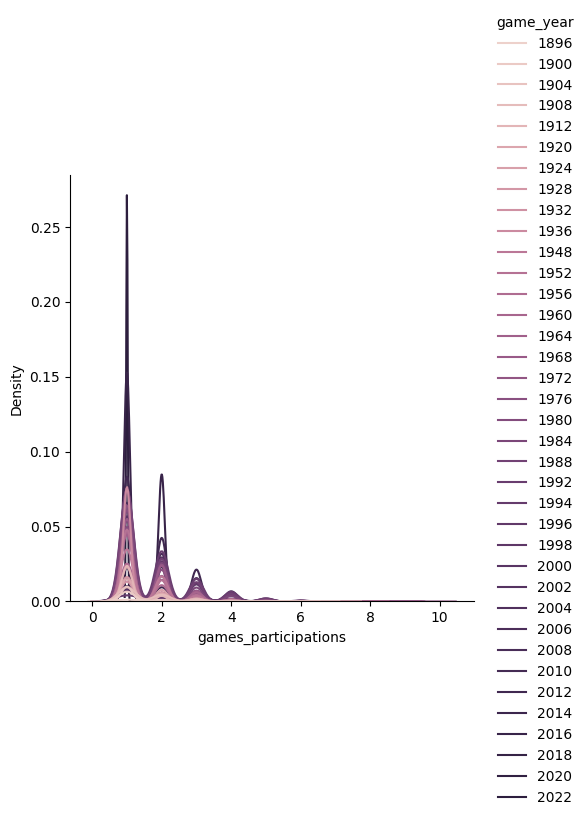

In [5]:

# Read the file olympic_hosts.csv
df_olympic_hosts = spark.read.csv("/content/olympic_hosts.csv", header=True, inferSchema=True)
df_olympic_hosts.show(5)

# Convert game_end_date and game_start_date columns to date format
df_olympic_hosts = df_olympic_hosts.withColumn("game_end_date", to_date(df_olympic_hosts["game_end_date"]))
df_olympic_hosts = df_olympic_hosts.withColumn("game_start_date", to_date(df_olympic_hosts["game_start_date"]))

# Change the names of the countries in the game_location
df_olympic_hosts = df_olympic_hosts.withColumn(
    'game_location',
    when(col('game_location') == 'German Democratic Republic (Germany)', 'Germany')
    .when(col('game_location') == 'Federal Republic of Germany', 'Germany')
    .when(col('game_location') == "Democratic People's Republic of Korea", 'North Korea')
    .when(col('game_location') == "Republic of Korea", 'South Korea')
    .when(col('game_location') == "People's Republic of China", 'China')
    .when(col('game_location') == "Islamic Republic of Iran", 'Iran')
    .when(col('game_location') == "United States of America", 'USA')
    .otherwise(col('game_location'))
)

df_olympic_hosts.describe().show()
df_olympic_hosts.printSchema()

# Lieux des jeux olympiques
df_olympic_hosts.select('game_name').distinct().show()

# Grouper par pays et compter le nombre de jeux, tout en récupérant les dates de début et de fin
df_grouped = df_olympic_hosts.groupBy("game_location") \
    .agg(
        count("*").alias("games_count"),
        collect_list("game_start_date").alias("start_dates"),
        collect_list("game_end_date").alias("end_dates")
    )

df_grouped.show(truncate=False)

# Données
game_counts = df_olympic_hosts.groupBy("game_location").count().orderBy("count", ascending=False).toPandas()

# Création du graphique
plt.figure(figsize=(12, 8))
plt.barh(game_counts["game_location"], game_counts["count"], color='skyblue')
plt.xlabel('Number of Occurrences')
plt.ylabel('Country')
plt.title('Number of Times the Game Occurred in Each Country')
plt.gca().invert_yaxis()  # Inversion de l'axe y pour afficher le pays avec le plus grand nombre d'occurrences en haut
plt.show()

# Join both tables
df_athletes_hosts = df_olympic_athletes.join(df_olympic_hosts, df_olympic_athletes.first_game == df_olympic_hosts.game_name, how="inner")

# Group by athlete_full_name and count the number of games_participations
athlete_participations = df_athletes_hosts.groupBy("athlete_full_name").agg({"games_participations": "sum"}).withColumnRenamed("sum(games_participations)", "total_participations")

# Convert PySpark DataFrame to Pandas DataFrame for plotting
athlete_participations_pd = athlete_participations.toPandas()
athlete_participations_pd.head()

# Sort the DataFrame by total participations and select the first 50 athletes
top_50_athletes_df = athlete_participations.orderBy(col("total_participations").desc()).limit(50)

# Convert to Pandas DataFrame
top_50_athletes_pd = top_50_athletes_df.toPandas()

# Plotting
plt.figure(figsize=(24, 16))
plt.bar(top_50_athletes_pd["athlete_full_name"], top_50_athletes_pd["total_participations"])
plt.xlabel("Athlete Names")
plt.ylabel("Total Participations")
plt.title("Total Participations of Athletes Over the Years")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

df_athletes_hosts_pd = df_athletes_hosts.toPandas()
sns.displot(data=df_athletes_hosts_pd, x="games_participations", hue="game_year", kind="kde")



+----------------+------------+-------------+------------+----------+----------------+-----------------+--------------------+--------------------+------------+------------+---------------------+
|discipline_title|   slug_game|  event_title|event_gender|medal_type|participant_type|participant_title|         athlete_url|   athlete_full_name|country_name|country_code|country_3_letter_code|
+----------------+------------+-------------+------------+----------+----------------+-----------------+--------------------+--------------------+------------+------------+---------------------+
|         Curling|beijing-2022|Mixed Doubles|       Mixed|      GOLD|        GameTeam|            Italy|https://olympics....|Stefania CONSTANTINI|       Italy|          IT|                  ITA|
|         Curling|beijing-2022|Mixed Doubles|       Mixed|      GOLD|        GameTeam|            Italy|https://olympics....|        Amos MOSANER|       Italy|          IT|                  ITA|
|         Curling|beijing

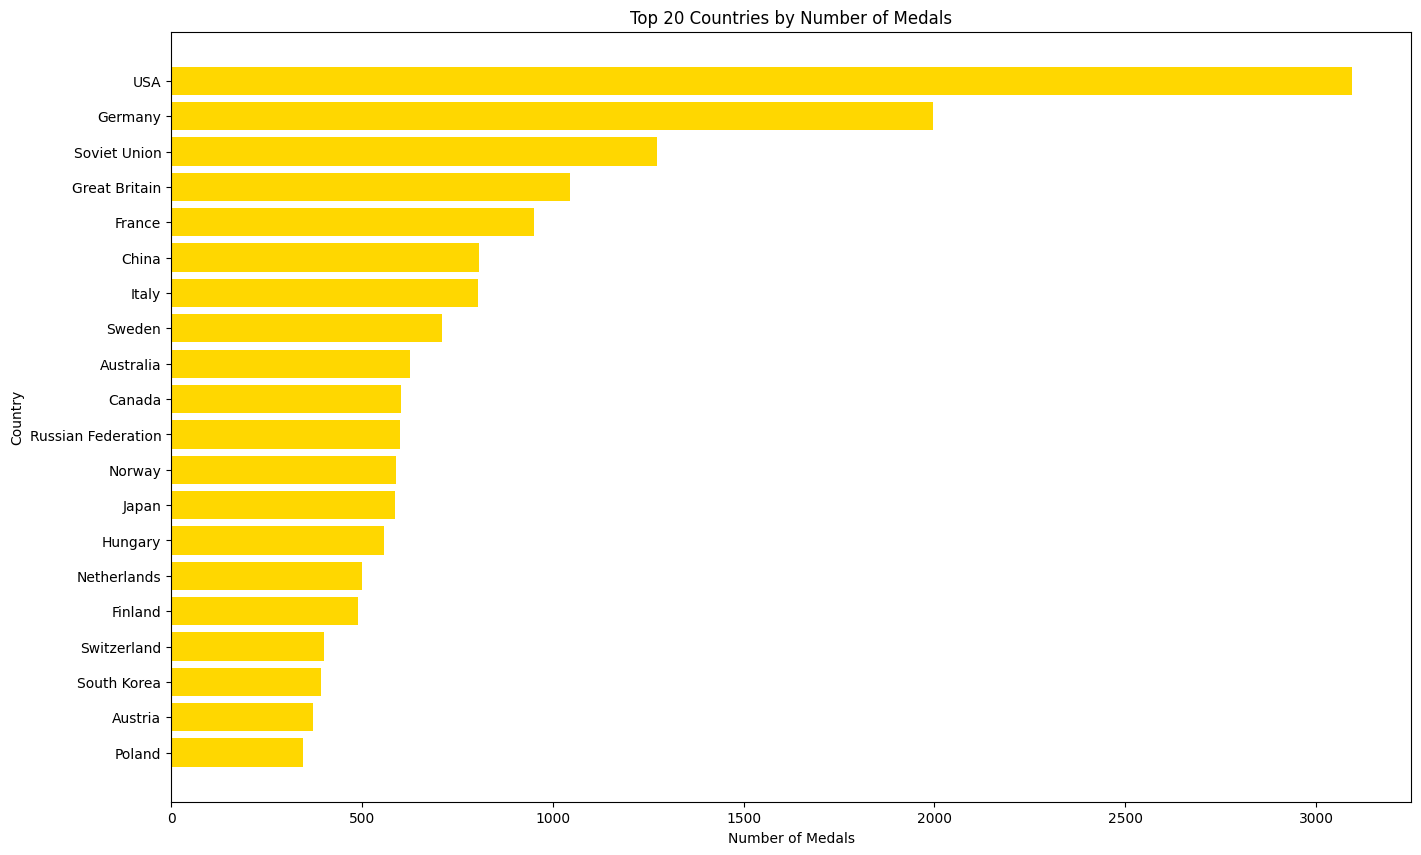

In [6]:
# Read the file olympic_medals.csv
df_olympic_medals = spark.read.csv("/content/olympic_medals.csv", header=True, inferSchema=True)
df_olympic_medals.show(5)
df_olympic_medals.describe().show()
df_olympic_medals.printSchema()

# Change the names of the countries in the country_name
df_olympic_medals = df_olympic_medals.withColumn(
    'country_name',
    when(col('country_name') == 'German Democratic Republic (Germany)', 'Germany')
    .when(col('country_name') == 'Federal Republic of Germany', 'Germany')
    .when(col('country_name') == "Democratic People's Republic of Korea", 'North Korea')
    .when(col('country_name') == "Republic of Korea", 'South Korea')
    .when(col('country_name') == "People's Republic of China", 'China')
    .when(col('country_name') == "Islamic Republic of Iran", 'Iran')
    .when(col('country_name') == "United States of America", 'USA')
    .otherwise(col('country_name'))
)

# Nettoyer les données : filtrer les lignes avec des valeurs de médailles non nulles
df_medals = df_olympic_medals.filter(col("medal_type").isNotNull())

# Grouper par pays et jeu (slug_game), et compter les athlètes uniques
df_grouped = df_medals.groupBy("country_name", "slug_game") \
    .agg(countDistinct("athlete_full_name").alias("athlete_count"))

# Nombre d'athlètes ayant remporté des médailles pour chaque pays et par jeux
df_grouped.show(truncate=False)

# Grouper par pays et compter le nombre de médailles
df_country_medals = df_medals.groupBy("country_name") \
    .agg(count("medal_type").alias("total_medals"))

# Trier les pays par le nombre total de médailles décroissant
df_sorted_medals = df_country_medals.orderBy(col("total_medals").desc())

# Sélectionner les 20 premiers pays
df_top_20_countries = df_sorted_medals.limit(20)

# Convertir en DataFrame Pandas pour la visualisation
df_top_20_countries_pd = df_top_20_countries.toPandas()

# Création du graphique
plt.figure(figsize=(16, 10))
plt.barh(df_top_20_countries_pd["country_name"], df_top_20_countries_pd["total_medals"], color='gold')
plt.xlabel('Number of Medals')
plt.ylabel('Country')
plt.title('Top 20 Countries by Number of Medals')
plt.gca().invert_yaxis()  # Inverser l'axe y pour afficher le pays avec le plus grand nombre de médailles en haut
plt.show()



In [7]:
# Read the file olympic_results.scv

df_olympic_results = spark.read.csv("/content/olympic_results.csv", header=True, inferSchema="True")
df_olympic_results.show(5)

+----------------+-------------+------------+----------------+----------+--------------------+----------+-------------+-------------+------------+---------------------+-----------+-----------------+----------+----------+
|discipline_title|  event_title|   slug_game|participant_type|medal_type|            athletes|rank_equal|rank_position| country_name|country_code|country_3_letter_code|athlete_url|athlete_full_name|value_unit|value_type|
+----------------+-------------+------------+----------------+----------+--------------------+----------+-------------+-------------+------------+---------------------+-----------+-----------------+----------+----------+
|         Curling|Mixed Doubles|beijing-2022|        GameTeam|      GOLD|[('Stefania CONST...|     False|            1|        Italy|          IT|                  ITA|       NULL|             NULL|      NULL|      NULL|
|         Curling|Mixed Doubles|beijing-2022|        GameTeam|    SILVER|[('Kristin SKASLI...|     False|           

In [8]:
# Change the names of the countries in the country_name
df_olympic_results = df_olympic_results.withColumn(
    'country_name',
    when(col('country_name') == 'German Democratic Republic (Germany)', 'Germany')
    .when(col('country_name') == 'Federal Republic of Germany', 'Germany')
    .when(col('country_name') == "Democratic People's Republic of Korea", 'North Korea')
    .when(col('country_name') == "Republic of Korea", 'South Korea')
    .when(col('country_name') == "People's Republic of China", 'China')
    .when(col('country_name') == "Islamic Republic of Iran", 'Iran')
    .when(col('country_name') == "United States of America", 'USA')
    .otherwise(col('country_name'))
)

In [7]:
df_olympic_results.describe().show()

+-------+----------------+--------------------+----------------+----------------+----------+--------------------+--------------------+--------------------+--------------------+------------+---------------------+--------------------+-----------------+------------------+-----------------+
|summary|discipline_title|         event_title|       slug_game|participant_type|medal_type|            athletes|          rank_equal|       rank_position|        country_name|country_code|country_3_letter_code|         athlete_url|athlete_full_name|        value_unit|       value_type|
+-------+----------------+--------------------+----------------+----------------+----------+--------------------+--------------------+--------------------+--------------------+------------+---------------------+--------------------+-----------------+------------------+-----------------+
|  count|          162804|              162804|          162804|          162804|     20206|                7976|               32555|  

In [8]:
# # Filter the DataFrame to include only rows where rank_position is 1
df_filtered = df_olympic_results.filter(col("rank_position") == 1)

# Group by slug_game, country_name, and athlete_full_name, and count the number of unique athletes
df_grouped = df_filtered.groupBy("slug_game", "country_name").agg(
    count("athlete_full_name").alias("athlete_count"),
    collect_list("athlete_full_name").alias("athletes")
)

# Explode the list of athletes to individual rows
df_exploded = df_grouped.withColumn("athlete", explode("athletes"))

# Sort the data by the count of athletes in descending order
df_sorted = df_exploded.orderBy(col("athlete_count").desc())

# Select the top 30 athletes for each slug_game and country_name
df_top_30 = df_sorted.groupBy("slug_game", "country_name").agg(
    collect_list("athlete").alias("top_30_athletes")
).orderBy("slug_game", ascending=False).limit(30)

In [9]:
# Renaming columns in each DataFrame to avoid ambiguity
df_olympic_athletes = df_olympic_athletes.withColumnRenamed('athlete_url', 'athletes_athlete_url') \
                                         .withColumnRenamed('athlete_full_name', 'athletes_athlete_full_name') \
                                         .withColumnRenamed('discipline_title', 'athletes_discipline_title') \
                                         .withColumnRenamed('slug_game', 'athletes_slug_game') \
                                         .withColumnRenamed('event_title', 'athletes_event_title') \
                                         .withColumnRenamed('medal_type', 'athletes_medal_type') \
                                         .withColumnRenamed('participant_type', 'athletes_participant_type') \
                                         .withColumnRenamed('country_name', 'athletes_country_name') \
                                         .withColumnRenamed('country_code', 'athletes_country_code') \
                                         .withColumnRenamed('country_3_letter_code', 'athletes_country_3_letter_code')

df_olympic_hosts = df_olympic_hosts.withColumnRenamed('athlete_url', 'hosts_athlete_url') \
                                   .withColumnRenamed('athlete_full_name', 'hosts_athlete_full_name') \
                                   .withColumnRenamed('discipline_title', 'hosts_discipline_title') \
                                   .withColumnRenamed('slug_game', 'hosts_slug_game') \
                                   .withColumnRenamed('event_title', 'hosts_event_title') \
                                   .withColumnRenamed('medal_type', 'hosts_medal_type') \
                                   .withColumnRenamed('participant_type', 'hosts_participant_type') \
                                   .withColumnRenamed('country_name', 'hosts_country_name') \
                                   .withColumnRenamed('country_code', 'hosts_country_code') \
                                   .withColumnRenamed('country_3_letter_code', 'hosts_country_3_letter_code')

df_olympic_medals = df_olympic_medals.withColumnRenamed('athlete_url', 'medals_athlete_url') \
                                     .withColumnRenamed('athlete_full_name', 'medals_athlete_full_name') \
                                     .withColumnRenamed('discipline_title', 'medals_discipline_title') \
                                     .withColumnRenamed('slug_game', 'medals_slug_game') \
                                     .withColumnRenamed('event_title', 'medals_event_title') \
                                     .withColumnRenamed('medal_type', 'medals_medal_type') \
                                     .withColumnRenamed('participant_type', 'medals_participant_type') \
                                     .withColumnRenamed('country_name', 'medals_country_name') \
                                     .withColumnRenamed('country_code', 'medals_country_code') \
                                     .withColumnRenamed('country_3_letter_code', 'medals_country_3_letter_code')

df_olympic_results = df_olympic_results.withColumnRenamed('athlete_url', 'results_athlete_url') \
                                       .withColumnRenamed('athlete_full_name', 'results_athlete_full_name') \
                                       .withColumnRenamed('discipline_title', 'results_discipline_title') \
                                       .withColumnRenamed('slug_game', 'results_slug_game') \
                                       .withColumnRenamed('event_title', 'results_event_title') \
                                       .withColumnRenamed('medal_type', 'results_medal_type') \
                                       .withColumnRenamed('participant_type', 'results_participant_type') \
                                       .withColumnRenamed('country_name', 'results_country_name') \
                                       .withColumnRenamed('country_code', 'results_country_code') \
                                       .withColumnRenamed('country_3_letter_code', 'results_country_3_letter_code')


In [10]:
df_athletes_hosts = df_olympic_athletes.join(df_olympic_hosts, df_olympic_athletes['first_game'] == df_olympic_hosts['game_name'], how='inner')

In [11]:
# Join the resulting DataFrame with df_olympic_medals on game_slug
df_athletes_hosts_medals = df_athletes_hosts.join(df_olympic_medals, df_athletes_hosts['game_slug'] == df_olympic_medals['medals_slug_game'], how='inner')

In [12]:
# Join the resulting DataFrame with df_olympic_results on game_slug
df = df_athletes_hosts_medals.join(df_olympic_results, df_athletes_hosts_medals['medals_slug_game'] == df_olympic_results['results_slug_game'], how='inner')

In [13]:
# Créer une colonne pour indiquer si l'athlète a gagné une médaille
df = df_athletes_hosts_medals.withColumn("won_medal", when(col("medals_medal_type").isNotNull(), 1).otherwise(0))

In [14]:
df.show()

+--------------------+--------------------------+--------------------+------------+------------------+--------------+----+------------+-------------+---------------+-------------+------------+-----------+---------+-----------------------+----------------+--------------------+------------+-----------------+-----------------------+--------------------+--------------------+------------------------+-------------------+-------------------+----------------------------+---------+
|athletes_athlete_url|athletes_athlete_full_name|games_participations|  first_game|athlete_year_birth|athlete_medals| bio|   game_slug|game_end_date|game_start_date|game_location|   game_name|game_season|game_year|medals_discipline_title|medals_slug_game|  medals_event_title|event_gender|medals_medal_type|medals_participant_type|   participant_title|  medals_athlete_url|medals_athlete_full_name|medals_country_name|medals_country_code|medals_country_3_letter_code|won_medal|
+--------------------+----------------------

In [14]:
# List of columns to keep
columns_to_keep = [
    'medals_country_name', 'games_participations',
     'game_location','game_season', 'game_year',
    'medals_discipline_title', 'medals_participant_type',
    'medals_athlete_full_name', 'medals_medal_type']

# Get all column names from the merged DataFrame
all_columns = df.columns

print(all_columns)

# Identify columns to drop (columns that are not in columns_to_keep)
columns_to_drop = [col for col in all_columns if col not in columns_to_keep]

# Now columns_to_drop contains the list of columns that you won't keep
print("Columns to drop:", columns_to_drop)

# Drop the unnecessary columns
df = df.drop(*columns_to_drop)

['athletes_athlete_url', 'athletes_athlete_full_name', 'games_participations', 'first_game', 'athlete_year_birth', 'athlete_medals', 'bio', 'game_slug', 'game_end_date', 'game_start_date', 'game_location', 'game_name', 'game_season', 'game_year', 'medals_discipline_title', 'medals_slug_game', 'medals_event_title', 'event_gender', 'medals_medal_type', 'medals_participant_type', 'participant_title', 'medals_athlete_url', 'medals_athlete_full_name', 'medals_country_name', 'medals_country_code', 'medals_country_3_letter_code', 'won_medal']
Columns to drop: ['athletes_athlete_url', 'athletes_athlete_full_name', 'first_game', 'athlete_year_birth', 'athlete_medals', 'bio', 'game_slug', 'game_end_date', 'game_start_date', 'game_name', 'medals_slug_game', 'medals_event_title', 'event_gender', 'participant_title', 'medals_athlete_url', 'medals_country_code', 'medals_country_3_letter_code', 'won_medal']


In [16]:
df.show(5)

+--------------------+-------------+-----------+---------+-----------------------+-----------------+-----------------------+------------------------+-------------------+
|games_participations|game_location|game_season|game_year|medals_discipline_title|medals_medal_type|medals_participant_type|medals_athlete_full_name|medals_country_name|
+--------------------+-------------+-----------+---------+-----------------------+-----------------+-----------------------+------------------------+-------------------+
|                   1|        China|     Winter|     2022|              Bobsleigh|           BRONZE|               GameTeam|          Sylvia HOFFMAN|                USA|
|                   1|        China|     Winter|     2022|              Bobsleigh|           BRONZE|               GameTeam|     Elana MEYERS TAYLOR|                USA|
|                   1|        China|     Winter|     2022|              Bobsleigh|           SILVER|               GameTeam|     Alexandra BURGHARDT| 

In [15]:


# Créer une colonne pour indiquer si l'athlète a gagné une médaille
df = df.withColumn("won_medal", when(col("medals_medal_type").isNotNull(), 1).otherwise(0))

# Sélectionner les colonnes pertinentes pour la modélisation
# df = df.select("athletes", "game_season","medals_medal_type","game_start_date", "games_participations", "results_country_name", "won_medal")

# # Supprimer les lignes avec des valeurs manquantes
df = df.dropna()

In [18]:
df.show()

+--------------------+-------------+-----------+---------+-----------------------+-----------------+-----------------------+------------------------+-------------------+---------+
|games_participations|game_location|game_season|game_year|medals_discipline_title|medals_medal_type|medals_participant_type|medals_athlete_full_name|medals_country_name|won_medal|
+--------------------+-------------+-----------+---------+-----------------------+-----------------+-----------------------+------------------------+-------------------+---------+
|                   1|        China|     Winter|     2022|              Bobsleigh|           BRONZE|               GameTeam|          Sylvia HOFFMAN|                USA|        1|
|                   1|        China|     Winter|     2022|              Bobsleigh|           BRONZE|               GameTeam|     Elana MEYERS TAYLOR|                USA|        1|
|                   1|        China|     Winter|     2022|              Bobsleigh|           SILVER|

In [19]:
# Filtrer les colonnes
# df = df.select(columns_to_keep)

In [20]:
# columns_to_keep = [
#     'athletes_athlete_full_name', 'games_participations',
#     'game_start_date', 'game_location','game_season', 'game_year',
#     'athletes_discipline_title', 'medals_participant_type',
#     'athletes_country_name', 'athletes',

# ]

# # Indexer les colonnes catégorielles
# indexers = [
#     StringIndexer(inputCol="athletes_athlete_full_name", outputCol="athletes_athlete_full_name_indexed"),
#     StringIndexer(inputCol="games_participations", outputCol="games_participations_indexed"),
#     StringIndexer(inputCol="game_start_date", outputCol="game_start_date_indexed"),
#     StringIndexer(inputCol="game_location", outputCol="game_location_indexed"),
#     StringIndexer(inputCol="game_season", outputCol="game_season_indexed"),
#     StringIndexer(inputCol="game_year", outputCol="game_year_indexed"),
#     StringIndexer(inputCol="athletes_discipline_title", outputCol="athletes_discipline_title_indexed"),
#     StringIndexer(inputCol="medals_participant_type", outputCol="medals_participant_type_indexed"),
#     StringIndexer(inputCol="athletes_country_name", outputCol="athletes_country_name_indexed"),
#     StringIndexer(inputCol="athletes", outputCol="athletes_indexed")


# ]

In [16]:
columns_to_keep = [
    'medals_country_name', 'games_participations',
     'game_location','game_season', 'game_year',
    'medals_discipline_title', 'medals_participant_type',
    'medals_athlete_full_name', 'medals_medal_type']

In [17]:
indexers = [
    ("medals_country_name", "medals_country_name_indexed"),
    ("games_participations", "games_participations_indexed"),
    ("game_location", "game_location_indexed"),
    ("game_season", "game_season_indexed"),
    ("game_year", "game_year_indexed"),
    ("medals_discipline_title", "medals_discipline_title_indexed"),
    ("medals_participant_type", "medals_participant_type_indexed"),
    ("medals_athlete_full_name", "medals_athlete_full_name_indexed"),
    ("medals_medal_type", "medals_medal_type_indexed")
]

In [23]:




# for indexer in indexers:
#     df = indexer.fit(df).transform(df)

# # Assembler les caractéristiques en un vecteur
# assembler = VectorAssembler(
#     inputCols=[
#         "athletes_athlete_full_name_indexed",
#          "games_participations_indexed",
#         "game_start_date_indexed",
#          "game_location_indexed",
#           "game_season_indexed",
#         "game_year_indexed",
#         "athletes_discipline_title_indexed",
#         "medals_participant_type_indexed",
#         "athletes_country_name_indexed",
#         "athletes_indexed",
#     ],
#     outputCol="features"
# )

In [18]:
for input_col, output_col in indexers:
    indexer = StringIndexer(inputCol=input_col, outputCol=output_col)
    df = indexer.fit(df).transform(df)

# Assembler les caractéristiques en un vecteur
assembler = VectorAssembler(
    inputCols=[output_col for _, output_col in indexers],
    outputCol="features"
)
df = assembler.transform(df)

In [25]:
df.show()

+--------------------+-------------+-----------+---------+-----------------------+-----------------+-----------------------+------------------------+-------------------+---------+---------------------------+----------------------------+---------------------+-------------------+-----------------+-------------------------------+-------------------------------+--------------------------------+-------------------------+--------------------+
|games_participations|game_location|game_season|game_year|medals_discipline_title|medals_medal_type|medals_participant_type|medals_athlete_full_name|medals_country_name|won_medal|medals_country_name_indexed|games_participations_indexed|game_location_indexed|game_season_indexed|game_year_indexed|medals_discipline_title_indexed|medals_participant_type_indexed|medals_athlete_full_name_indexed|medals_medal_type_indexed|            features|
+--------------------+-------------+-----------+---------+-----------------------+-----------------+------------------

In [19]:

# Séparer les données en ensembles d'entraînement et de test
train_df, test_df = df.randomSplit([0.8, 0.3], seed=42)

# Initialiser le modèle MLP
mlp = MultilayerPerceptronClassifier(layers=[5, 10, 10, 2], seed=42, labelCol="won_medal", featuresCol="features")
print(mlp)



MultilayerPerceptronClassifier_4d1cd8aafc64


In [ ]:
# Entraîner le modèle
model = mlp.fit(train_df)

print(model)

# Faire des prédictions sur l'ensemble de test
predictions = model.transform(test_df)
print(predictions)

In [ ]:
# Évaluer le modèle
evaluator = MulticlassClassificationEvaluator(labelCol="won_medal", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(accuracy)
print(f"Accuracy: {accuracy:.4f}")

In [ ]:
# Matrice de confusion
prediction_and_labels = predictions.select("prediction", "won_medal")
prediction_and_labels_pd = prediction_and_labels.toPandas()
confusion_matrix = pd.crosstab(prediction_and_labels_pd["won_medal"], prediction_and_labels_pd["prediction"], rownames=["Actual"], colnames=["Predicted"])
sns.heatmap(confusion_matrix, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.show()